In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Deep Learning/data_lab2.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


(432, 300, 3)


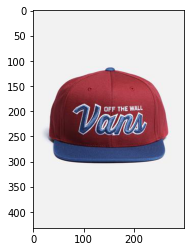

In [ ]:
# un exemple de lecture/affichage d'une image
img=plt.imread("/content/data/train/accessories/productimg_1.jpg")
plt.imshow(img)
print(img.shape)

In [ ]:
img2 = cv2.resize(cv2.imread("/content/data/train/accessories/productimg_1.jpg"),(150,150),interpolation=cv2.INTER_CUBIC)

In [ ]:
# Chargement de toutes les uimages:
path="/content/data/"
train_dir = path+"train/"
test_dir = path+"validation/"
from sklearn.utils import shuffle

# Je redimensionne toutes nos images à une taille de 266x150x3 (surtout pour accélérer la phase d'apprentissage). 
# Les étiquettes sont encodées au format one-hot, ce qui signifie qu'elles sont représentées comme un de longueur n (le nombre de classe) avec la valeur 1 sur l'index d'étiquette associé et 0 sur les autres. 
# Les images sont mélangées (on utilise pour cela shuffle())

rows=266
columns=150

def read_process(dataset,columns,rows,rand=True):
    labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
    dir=path+dataset+"/"
    X,Y=[],[]
    for j,label in enumerate(labels):
        for file in os.listdir(dir+label+"/"):
            X.append(cv2.resize(cv2.imread(dir+label+"/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
            y=[0 for _ in range(len(labels))]
            y[j]=1
            Y.append(y)
    if rand : 
        return shuffle(np.array(X),np.array(Y))
    else:
        return np.array(X),np.array(Y)

def read_process_test(columns,rows):
    X_test=[]
    for file in os.listdir("/content/data/test/unknown"):
      X_test.append(cv2.resize(cv2.imread("/content/data/test/unknown/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
    return np.array(X_test)

X_train,Y_train=read_process("train",columns,rows)
X_val,Y_val=read_process("valid",columns,rows)
X_test=read_process_test(150,266)

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape)

(3467, 266, 150, 3) (3467, 8)
(382, 266, 150, 3) (382, 8)
(8, 266, 150, 3)


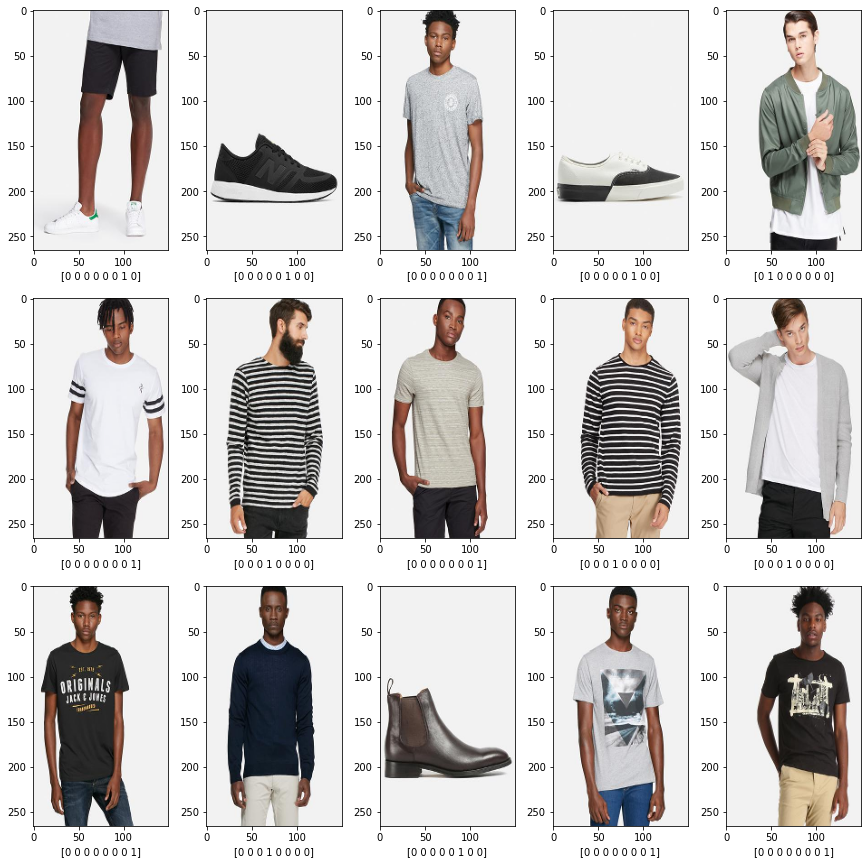

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,15))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(str(Y_train[i]))
    plt.sca(ax)
plt.show()

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

"""To create our model, we are going to use an architecture insired from
vggnet https://arxiv.org/pdf/1409.1556.pdf, in which you can see below
that our filter size increases as we go down layers
32 → 64 →128 →512—and final layer is 1"""
model = models.Sequential() # (1)
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(266,150, 3)))#(2)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) # (3)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) # (4)
model.add(layers.Dropout(0.5)) #Dropout for regularization # (5)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='sigmoid')) # (6) #Sigmoid function at the end because we have just two classes

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
#Create the image generators
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32
                                 
history = model.fit(x=X_train,y=Y_train,steps_per_epoch=ntrain // batch_size,epochs=20,validation_data=(X_val,Y_val),validation_steps=nval // batch_size)

Epoch 1/20
108/108 [==============================] - 16s 57ms/step - loss: 4.6923 - acc: 0.6136 - val_loss: 0.6548 - val_acc: 0.7723
Epoch 2/20
108/108 [==============================] - 5s 46ms/step - loss: 0.6039 - acc: 0.8013 - val_loss: 0.5572 - val_acc: 0.8534
Epoch 3/20
108/108 [==============================] - 5s 46ms/step - loss: 0.4467 - acc: 0.8517 - val_loss: 0.3792 - val_acc: 0.8770
Epoch 4/20
108/108 [==============================] - 5s 46ms/step - loss: 0.3246 - acc: 0.8862 - val_loss: 0.3456 - val_acc: 0.8743
Epoch 5/20
108/108 [==============================] - 5s 46ms/step - loss: 0.2394 - acc: 0.9142 - val_loss: 0.3215 - val_acc: 0.8927
Epoch 6/20
108/108 [==============================] - 5s 46ms/step - loss: 0.1905 - acc: 0.9326 - val_loss: 0.4074 - val_acc: 0.8822
Epoch 7/20
108/108 [==============================] - 5s 48ms/step - loss: 0.1718 - acc: 0.9403 - val_loss: 0.3356 - val_acc: 0.9005
Epoch 8/20
108/108 [==============================] - 5s 47ms/step -

108/108 [==============================] - 3s 30ms/step - loss: 0.0398 - acc: 0.9869 - val_loss: 0.4782 - val_acc: 0.9188


In [ ]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

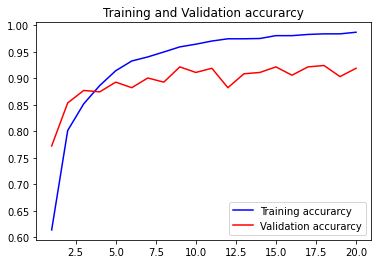

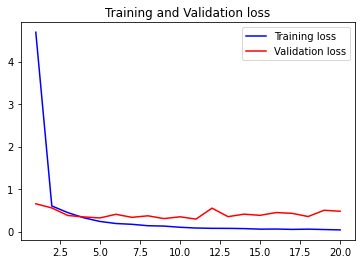

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

De cette manière, on remarque que le modèle est légèrement surentrainé. Essayons d'augmenter le nombre de données pour résoudre ce problème. 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, #Scale the image between 0 and 1
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255) #We do not augment validation data. we only perform rescale

In [ ]:
train_generator = train_datagen.flow(X_train, Y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size
                                 )
history = model.fit_generator(train_generator,steps_per_epoch=ntrain // batch_size,epochs=20,validation_data=val_generator,validation_steps=nval // batch_size)

<ipython-input-20-38145aba2589>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,steps_per_epoch=ntrain // batch_size,epochs=20,validation_data=val_generator,validation_steps=nval // batch_size)


Epoch 1/20
108/108 [==============================] - 35s 313ms/step - loss: 1.6029 - acc: 0.4850 - val_loss: 0.9458 - val_acc: 0.6591
Epoch 2/20
108/108 [==============================] - 29s 269ms/step - loss: 1.1652 - acc: 0.5956 - val_loss: 0.6855 - val_acc: 0.7926
Epoch 3/20
108/108 [==============================] - 29s 273ms/step - loss: 1.0642 - acc: 0.6227 - val_loss: 0.5462 - val_acc: 0.8352
Epoch 4/20
108/108 [==============================] - 29s 271ms/step - loss: 0.9750 - acc: 0.6556 - val_loss: 0.4856 - val_acc: 0.8352
Epoch 5/20
108/108 [==============================] - 29s 272ms/step - loss: 0.9139 - acc: 0.6763 - val_loss: 0.4974 - val_acc: 0.8267
Epoch 6/20
108/108 [==============================] - 31s 287ms/step - loss: 0.8639 - acc: 0.6908 - val_loss: 0.4212 - val_acc: 0.8409
Epoch 7/20
108/108 [==============================] - 29s 270ms/step - loss: 0.7912 - acc: 0.7156 - val_loss: 0.4477 - val_acc: 0.8352
Epoch 8/20
108/108 [==============================] - 2

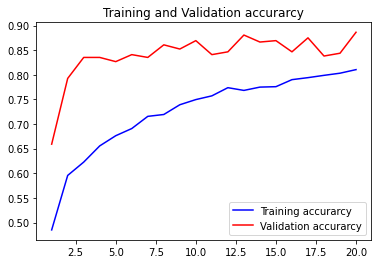

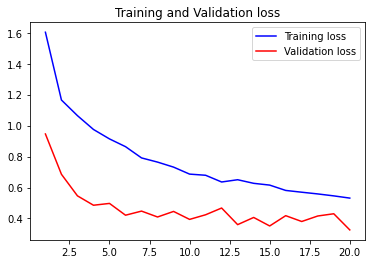

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

On remarque qu'ici le modele a plus de mal sur le jeu d'entrainement. Peut-être qu'une augmentation ne permet plus de catégoriser les données (ex : un zoom trop important). 

In [ ]:
# In this part, we use major pretrained model with ImageNet to observes their predictions. 
# The examples below are dedicated to VGG16 but are appliable to other CNN architectures. 
# Their input shape is 224x224 so it is necessary to resize all the images.

import numpy as np
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet

X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

vgg_model = vgg16.VGG16(weights='imagenet')

#inception_model = inception_v3.InceptionV3(weights='imagenet')

#resnet_model = resnet50.ResNet50(weights='imagenet')

#mobilenet_model = mobilenet.MobileNet(weights='imagenet')

1/1 [==============================] - 8s 8s/step


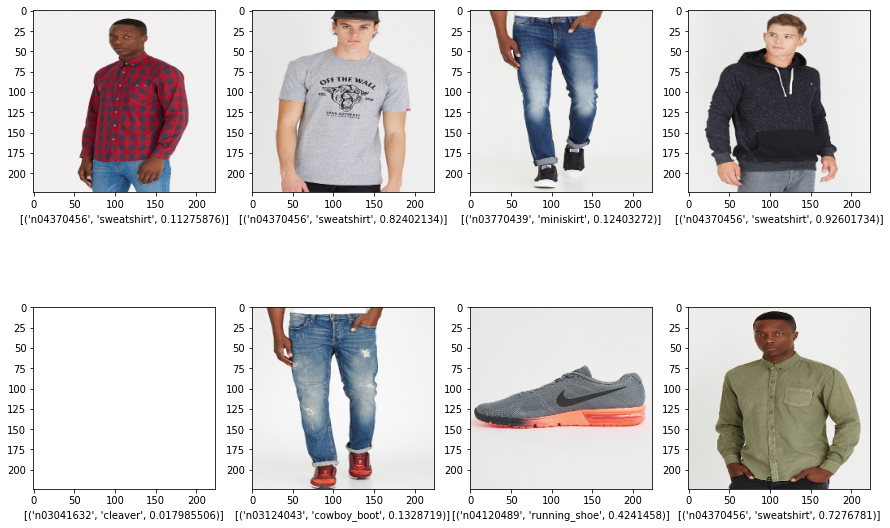

In [ ]:
X_test=read_process_test(224,224)

processed_image = vgg16.preprocess_input(X_test)
predictions = vgg_model.predict(processed_image)

Y_test=vgg16.decode_predictions(predictions,top=1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(Y_test[i])
    plt.sca(ax)
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16

batch_size=32

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

nTrain = len(X_train)
nVal = len(X_val)

train_features,val_features = conv_base.predict(X_train),conv_base.predict(X_val)
train_features,val_features = np.reshape(train_features, (nTrain, 7 * 7 * 512)),np.reshape(val_features, (nVal, 7 * 7 * 512))

print(train_features.shape,Y_train.shape)
print(val_features.shape,Y_val.shape)

12/12 [==============================] - 4s 375ms/step
(3467, 25088) (3467, 8)
(382, 25088) (382, 8)


1/1 [==============================] - 1s 910ms/step


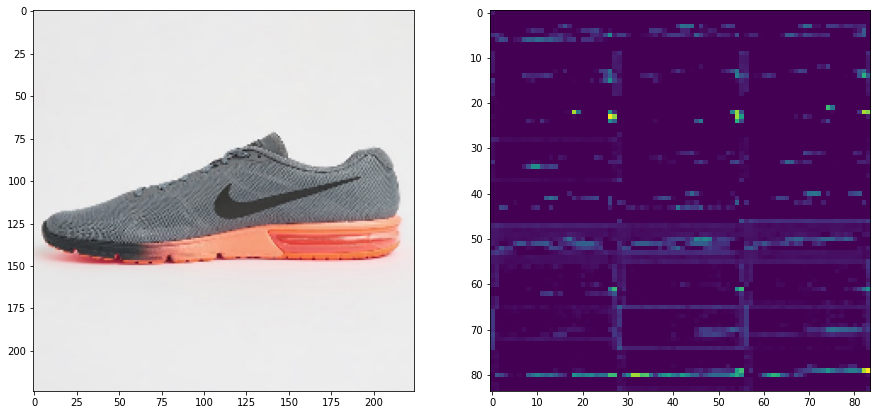

In [ ]:
X_test=read_process_test(224,224)[-1]
conv_base_demo=models.Sequential()
for i in range(11):
    conv_base_demo.add(conv_base.layers[i])
predictions = conv_base_demo.predict(np.array([X_test]))

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.imshow(cv2.cvtColor(X_test, cv2.COLOR_BGR2RGB))
output=[]
for i in range(3):
    row=[]
    for j in range(3):
        pred=predictions[0,:,:,3*i+j]
        row.append(pred)
    output.append(row)
ax2.imshow(np.reshape(output,(84,84)))
plt.show()

In [ ]:
model2 = models.Sequential()
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(8, activation='softmax'))
#print(model2.summary())

In [ ]:
model2.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
history = model2.fit(x=train_features,y=Y_train,steps_per_epoch=ntrain // batch_size,epochs=20,validation_data=(val_features,Y_val),validation_steps=nval // batch_size)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
108/108 [==============================] - 1s 8ms/step - loss: 2.9758 - acc: 0.8143 - val_loss: 0.6743 - val_acc: 0.9293
Epoch 2/20
108/108 [==============================] - 1s 7ms/step - loss: 0.6302 - acc: 0.9131 - val_loss: 0.4267 - val_acc: 0.9424
Epoch 3/20
108/108 [==============================] - 1s 6ms/step - loss: 0.3846 - acc: 0.9391 - val_loss: 0.4186 - val_acc: 0.9476
Epoch 4/20
108/108 [==============================] - 1s 7ms/step - loss: 0.2297 - acc: 0.9607 - val_loss: 0.3909 - val_acc: 0.9529
Epoch 5/20
108/108 [==============================] - 1s 7ms/step - loss: 0.2038 - acc: 0.9674 - val_loss: 0.5136 - val_acc: 0.9450
Epoch 6/20
108/108 [==============================] - 1s 6ms/step - loss: 0.1903 - acc: 0.9694 - val_loss: 0.4306 - val_acc: 0.9634
Epoch 7/20
108/108 [==============================] - 1s 6ms/step - loss: 0.1314 - acc: 0.9788 - val_loss: 0.7607 - val_acc: 0.9398
Epoch 8/20
108/108 [==============================] - 1s 6ms/step - loss: 0.

108/108 [==============================] - 0s 4ms/step - loss: 0.0217 - acc: 0.9955 - val_loss: 1.0123 - val_acc: 0.9476


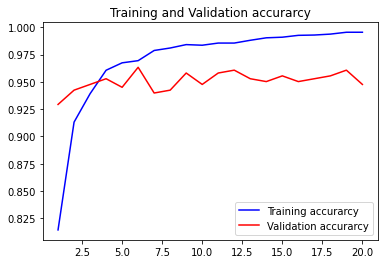

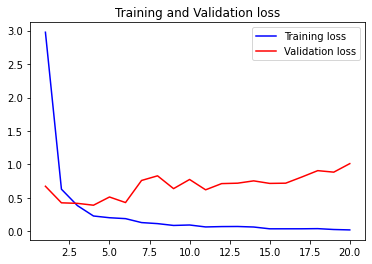

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

On observe un léger sur entrainement mais cela semble normal vu que l'on a pris les features telles quelles sans réentrainer les dernières couches de convolution. 


1/1 [==============================] - 0s 41ms/step


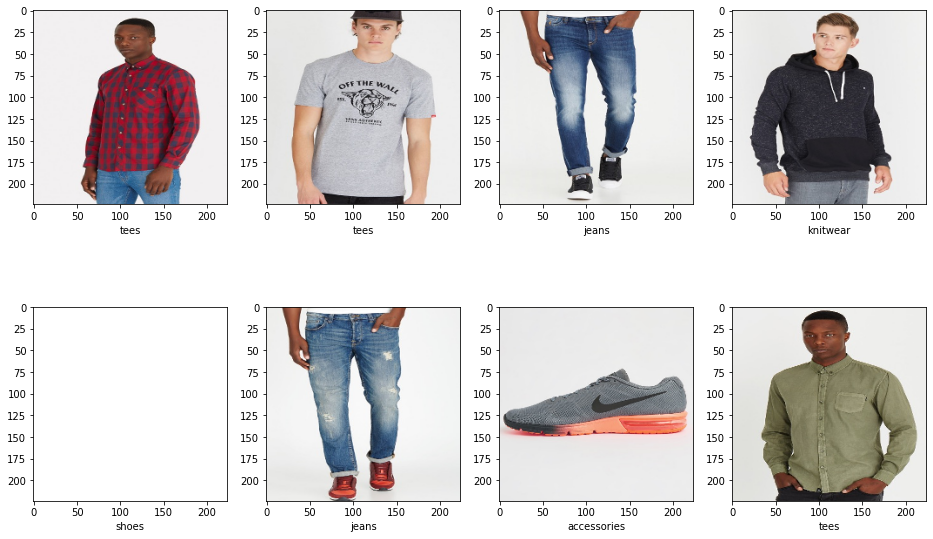

In [ ]:
labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X_test=read_process_test(224,224)
Y_test=model2.predict(np.reshape(conv_base.predict(X_test/255),(len(X_test),7*7*512)))
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(labels[np.argmax(Y_test[i])])
    plt.sca(ax)
plt.show()

In [ ]:
model12 = models.Sequential()
model12.add(conv_base)
model12.add(layers.Flatten())
model12.add(layers.Dense(256, activation='relu'))
model12.add(layers.Dense(8, activation='sigmoid'))
conv_base.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                   width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   vertical_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

In [ ]:
model12.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
history = model12.fit_generator(train_generator,steps_per_epoch=nTrain // batch_size,epochs=20,validation_data=val_generator,validation_steps=nVal // batch_size)

<ipython-input-17-8eff1bbb56d0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model12.fit_generator(train_generator,steps_per_epoch=nTrain // batch_size,epochs=20,validation_data=val_generator,validation_steps=nVal // batch_size)


Epoch 1/20
108/108 [==============================] - 42s 374ms/step - loss: 0.9237 - acc: 0.6946 - val_loss: 0.3412 - val_acc: 0.8920
Epoch 2/20
108/108 [==============================] - 41s 379ms/step - loss: 0.4644 - acc: 0.8399 - val_loss: 0.2830 - val_acc: 0.9091
Epoch 3/20
108/108 [==============================] - 40s 368ms/step - loss: 0.3793 - acc: 0.8635 - val_loss: 0.2261 - val_acc: 0.9205
Epoch 4/20
108/108 [==============================] - 41s 380ms/step - loss: 0.3430 - acc: 0.8754 - val_loss: 0.2312 - val_acc: 0.9091
Epoch 5/20
108/108 [==============================] - 42s 387ms/step - loss: 0.3139 - acc: 0.8897 - val_loss: 0.2582 - val_acc: 0.9119
Epoch 6/20
108/108 [==============================] - 40s 371ms/step - loss: 0.2899 - acc: 0.8964 - val_loss: 0.2561 - val_acc: 0.8977
Epoch 7/20
108/108 [==============================] - 40s 372ms/step - loss: 0.2762 - acc: 0.8955 - val_loss: 0.2016 - val_acc: 0.9318
Epoch 8/20
108/108 [==============================] - 4

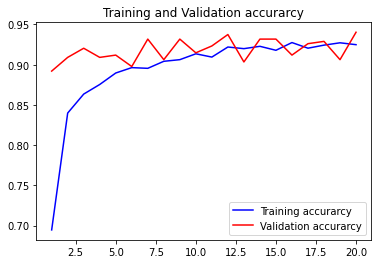

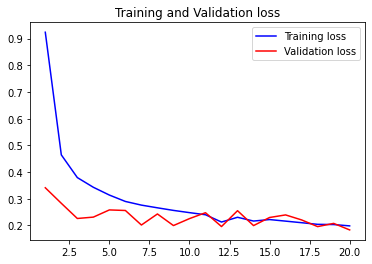

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
conv_base = VGG16(weights='imagenet',                  
                  include_top=False,                  
                  input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in conv_base.layers[:-4]:    
  layer.trainable = False
  # Check the trainable status of the individual layers
  for layer in conv_base.layers:    
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc86c750880> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc88402f8b0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc88402f700> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc8844919a0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc884485310> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8842b2220> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc86c70bd00> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc8842b2c70> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc86c773a90> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc86c773df0> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc8844b6760> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc86c6fbd60> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc884550250> True
<keras.layers.convolutional.conv2d

In [ ]:
model112 = models.Sequential()
model112.add(conv_base)
model112.add(layers.Flatten())
model112.add(layers.Dense(256, activation='relu'))
model112.add(layers.Dense(8, activation='sigmoid'))

In [ ]:
model112.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
history = model112.fit_generator(train_generator,steps_per_epoch=nTrain // batch_size,epochs=20,validation_data=val_generator,validation_steps=nVal // batch_size)

<ipython-input-21-7e42c86e113e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model112.fit_generator(train_generator,steps_per_epoch=nTrain // batch_size,epochs=20,validation_data=val_generator,validation_steps=nVal // batch_size)


Epoch 1/20
108/108 [==============================] - 44s 389ms/step - loss: 0.7215 - acc: 0.7523 - val_loss: 0.2138 - val_acc: 0.9148
Epoch 2/20
108/108 [==============================] - 41s 378ms/step - loss: 0.3361 - acc: 0.8824 - val_loss: 0.1903 - val_acc: 0.9233
Epoch 3/20
108/108 [==============================] - 42s 389ms/step - loss: 0.2512 - acc: 0.9068 - val_loss: 0.2221 - val_acc: 0.9148
Epoch 4/20
108/108 [==============================] - 41s 379ms/step - loss: 0.2184 - acc: 0.9223 - val_loss: 0.2090 - val_acc: 0.9205
Epoch 5/20
108/108 [==============================] - 41s 378ms/step - loss: 0.1851 - acc: 0.9319 - val_loss: 0.2027 - val_acc: 0.9347
Epoch 6/20
108/108 [==============================] - 41s 379ms/step - loss: 0.1871 - acc: 0.9357 - val_loss: 0.2020 - val_acc: 0.9375
Epoch 7/20
108/108 [==============================] - 43s 393ms/step - loss: 0.1634 - acc: 0.9453 - val_loss: 0.2684 - val_acc: 0.9375
Epoch 8/20
108/108 [==============================] - 4

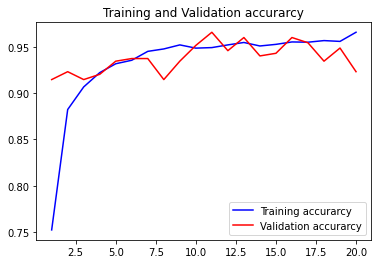

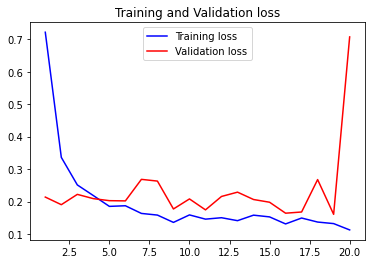

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()